# SC1015 DSAI Project:
### [Toxic Comment Classification Challenge Dataset from Kaggle](https://www.kaggle.com/competitions/jigsaw-toxic-comment-classification-challenge/overview)

In [5]:
## Import Relevant Libraries
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
import tensorflow as tf
from textblob import TextBlob,Word
from matplotlib.ticker import PercentFormatter

## Setup : Import the Dataset
The dataset `train.csv` is in CSV format, hence we use the `read_csv` function from Pandas, and take a quick look at the data using the head function.

In [6]:
df = pd.read_csv("train.csv")
df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\r\nWhy the edits made under my use...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\r\nMore\r\nI can't make any real suggestions...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


Entries with all 0 under the 6 categories are considered as non-toxic.</br> 

In [353]:
# Check the shape of object type in the dataset using the .info() method
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   id             159571 non-null  object
 1   comment_text   159571 non-null  object
 2   toxic          159571 non-null  int64 
 3   severe_toxic   159571 non-null  int64 
 4   obscene        159571 non-null  int64 
 5   threat         159571 non-null  int64 
 6   insult         159571 non-null  int64 
 7   identity_hate  159571 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 9.7+ MB


## Data Cleaning

check null value in dataset, need to clean dataset if there is missing values

In [354]:
#find the null values of the df
df.isnull().sum()

id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: int64

Text preprocessing steps - remove numbers, capital letters, punctuation, '\n'

In [355]:
import re
import string

# Remove all '\n' in the string and replace it with a space
rm_breakline = lambda x: re.sub("\n", " ", x)

# Remove all non-ascii characters 
rm_non_ascii = lambda x: re.sub(r'[^\x00-\x7f]',r' ', x)

# Apply all the lambda functions wrote previously through .map on the comments column
df['comment_text'] = df['comment_text'].map(rm_breakline).map(rm_non_ascii)

df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation Why the edits made under my userna...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,""" More I can't make any real suggestions on im...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


make sure columns: toxic, severe_toxic, obscene, threat, insult, and identity_hate have no other value other than 0 and 1

In [356]:
print("Max Value")
#find the max value to every column
print(df[df.columns[2:8]].max())
print("\nMin Value")
#find the min value to every column
print(df[df.columns[2:8]].min())
#find the distinct value of every column
print("\nDistinct Value of all column")
print(pd.unique(df[df.columns[2:8]].values.ravel()))

Max Value
toxic            1
severe_toxic     1
obscene          1
threat           1
insult           1
identity_hate    1
dtype: int64

Min Value
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: int64

Distinct Value of all column
[0 1]


## Exploratory Data Analysis

In [357]:
from textblob import TextBlob,Word

In [358]:
df[2:]

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,""" More I can't make any real suggestions on im...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0
5,00025465d4725e87,""" Congratulations from me as well, use the to...",0,0,0,0,0,0
6,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0
...,...,...,...,...,...,...,...,...
159566,ffe987279560d7ff,""":::::And for the second time of asking, when ...",0,0,0,0,0,0
159567,ffea4adeee384e90,You should be ashamed of yourself That is a ...,0,0,0,0,0,0
159568,ffee36eab5c267c9,"Spitzer Umm, theres no actual article for pr...",0,0,0,0,0,0
159569,fff125370e4aaaf3,And it looks like it was actually you who put ...,0,0,0,0,0,0


### Group Comment into Negative, Neutral and Positive Comment

In [359]:
def polarity(x):
    if TextBlob(x).sentiment[0] > 0.25:
        return 'Positive'
    else:
        return 'Neutral'

def sentiment(x):
    cols_to_check = df.columns[2:8]
    if any(df.loc[x.name, cols_to_check] == 1):
        return 'Negative'
    else:
        return polarity(x['comment_text'])

In [360]:
df['sentiment'] = df.apply(sentiment, axis=1)

In [361]:
df

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,sentiment
0,0000997932d777bf,Explanation Why the edits made under my userna...,0,0,0,0,0,0,Neutral
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,Positive
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,Neutral
3,0001b41b1c6bb37e,""" More I can't make any real suggestions on im...",0,0,0,0,0,0,Neutral
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,Neutral
...,...,...,...,...,...,...,...,...,...
159566,ffe987279560d7ff,""":::::And for the second time of asking, when ...",0,0,0,0,0,0,Neutral
159567,ffea4adeee384e90,You should be ashamed of yourself That is a ...,0,0,0,0,0,0,Neutral
159568,ffee36eab5c267c9,"Spitzer Umm, theres no actual article for pr...",0,0,0,0,0,0,Neutral
159569,fff125370e4aaaf3,And it looks like it was actually you who put ...,0,0,0,0,0,0,Neutral


### Percentage of Comment falls under Negative, Neutral and Positive Comment

In [406]:
count = df['sentiment'].value_counts()
perc = df['sentiment'].value_counts(normalize=True)
pd.DataFrame({'counts': count, 'percentages': perc})

,counts,percentages
Neutral,118597,0.743224
Positive,24749,0.155097
Negative,16225,0.101679


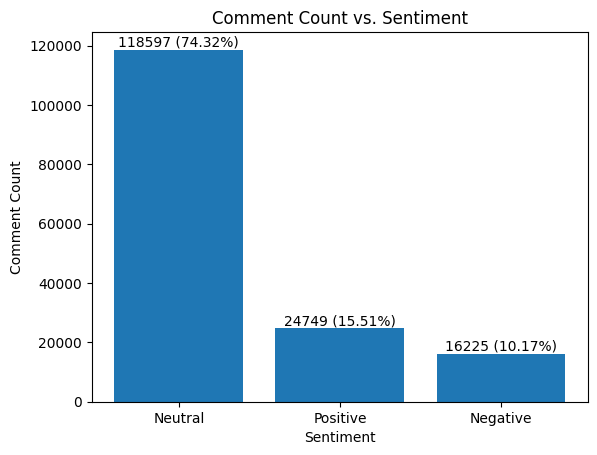

In [410]:
# sample data
categories = df['sentiment'].unique().tolist()
values = df['sentiment'].value_counts().tolist()

# calculate percentages
total = sum(values)
percentages = [(value / total) * 100 for value in values]

# plot the bar graph
fig, ax = plt.subplots()
ax.bar(categories, values)
ax.set_title('Comment Count vs. Sentiment')
ax.set_xlabel('Sentiment')
ax.set_ylabel('Comment Count')

# add percentages as annotations above each bar
for i, value in enumerate(values):
    ax.annotate(f'{value} ({percentages[i]:.2f}%)', xy=(i, value), ha='center', va='bottom')

plt.show()

### Percentage of Negative Comment falls under toxic, severe_toxic, obscene, threat, insult, identity_hate

In [364]:
df.columns[2:8]

Index(['toxic', 'severe_toxic', 'obscene', 'threat', 'insult',
       'identity_hate'],
      dtype='object')

number of rows that have 1 in more that 1 category eg. comment id:0002bcb3da6cb337 under toxic,severe toxic,obscene,insult

In [365]:
len(df[(df.iloc[:, 2:8] == 1).sum(axis=1) > 1])

9865

In [366]:
count = df[df.columns[2:8]].sum()
perc = df[df.columns[2:8]].sum()/len(df[df['sentiment']=='Negative'])
pd.DataFrame({'counts': count, 'percentages': perc})

,counts,percentages
toxic,15294,0.942619
severe_toxic,1595,0.098305
obscene,8449,0.520740
threat,478,0.029461
insult,7877,0.485485
identity_hate,1405,0.086595


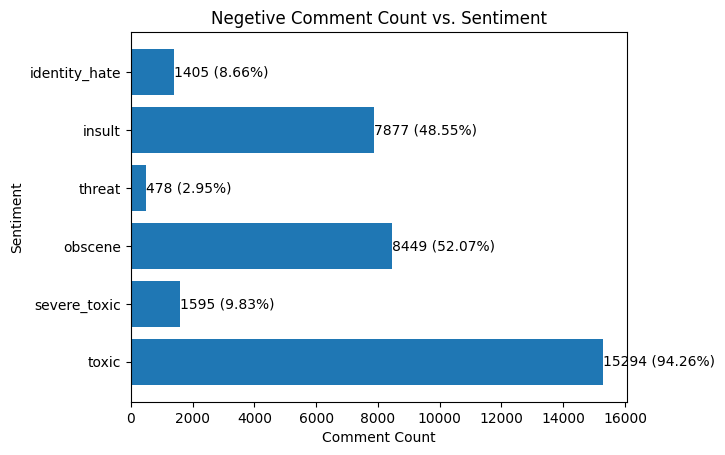

In [367]:
# sample data
categories = df.columns[2:8].tolist()
values = df[df.columns[2:8]].sum().tolist()

# calculate percentages
total = len(df[df['sentiment']=='Negative'])
percentages = [(value / total) * 100 for value in values]

# plot the horizontal bar graph
fig, ax = plt.subplots()
ax.barh(categories, values)
ax.set_title('Negetive Comment Count vs. Sentiment')
ax.set_xlabel('Comment Count')
ax.set_ylabel('Sentiment')

# add percentages as annotations to the right of each bar
for i, value in enumerate(values):
    ax.annotate(f'{value} ({percentages[i]:.2f}%)', xy=(value, i), ha='left', va='center')

plt.show()

### Length of comment fall under Sentiment: Negative, Neutral and Positive

In [368]:
#add word_count column
df['word_count'] = df['comment_text'].apply(lambda x: len(x.split()))

In [369]:
categories=df['sentiment'].unique().tolist()
category_word_count= []
for i in categories:
    category_word_count.append(int(df.loc[df['sentiment'] == i, ['word_count']].sum()))

pd.DataFrame({'categories': categories, 'word_count': category_word_count})

,categories,word_count
0,Neutral,8543469
1,Positive,1332116
2,Negative,855544


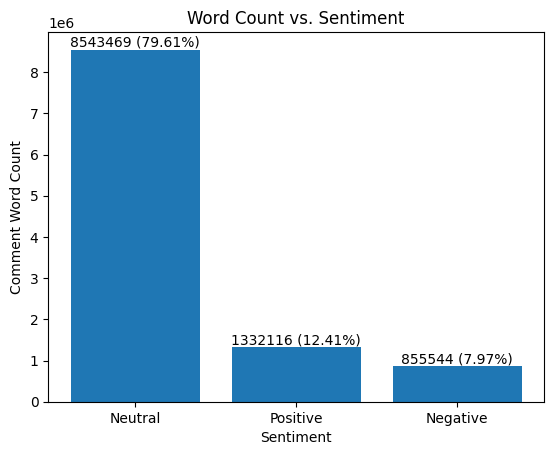

In [370]:
values = category_word_count

# calculate percentages
total = sum(values)
percentages = [(value / total) * 100 for value in values]

# plot the bar graph
fig, ax = plt.subplots()
ax.bar(categories, values)
ax.set_title('Word Count vs. Sentiment')
ax.set_xlabel('Sentiment')
ax.set_ylabel('Comment Word Count')

# add percentages as annotations above each bar
for i, value in enumerate(values):
    ax.annotate(f'{value} ({percentages[i]:.2f}%)', xy=(i, value), ha='center', va='bottom')

### Length of Negative comment under toxic, severe_toxic, obscene, threat, insult, identity_hate

In [371]:
categories=df.columns[2:8].tolist()
category_word_count= []
for i in categories:
    category_word_count.append(int(df.loc[df[i] == 1, ['word_count']].sum()))

pd.DataFrame({'categories': categories, 'word_count': category_word_count})

,categories,word_count
0,toxic,784564
1,severe_toxic,120630
2,obscene,418879
3,threat,26432
4,insult,380354
5,identity_hate,73131


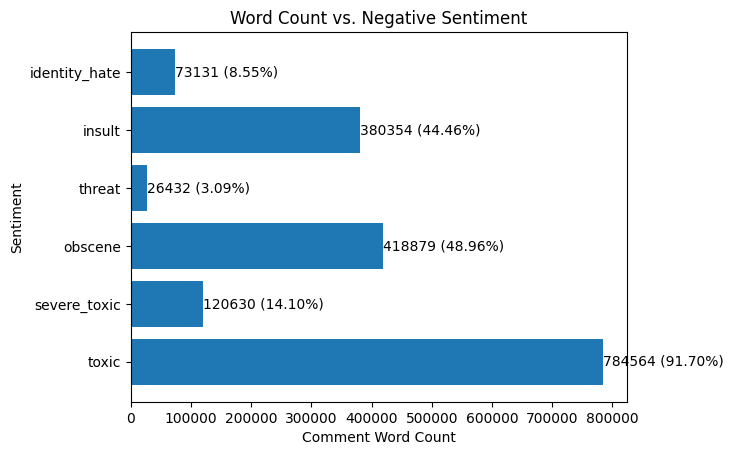

In [372]:
# sample data
values = category_word_count

# calculate percentages
total = int(df.loc[df['sentiment'] == 'Negative', ['word_count']].sum())
percentages = [(value / total) * 100 for value in values]

# plot the horizontal bar graph
fig, ax = plt.subplots()
ax.barh(categories, values)
ax.set_title('Word Count vs. Negative Sentiment')
ax.set_xlabel('Comment Word Count')
ax.set_ylabel('Sentiment')

# add percentages as annotations to the right of each bar
for i, value in enumerate(values):
    ax.annotate(f'{value} ({percentages[i]:.2f}%)', xy=(value, i), ha='left', va='center')

plt.show()

### Average Length of comment fall under Sentiment: Negative, Neutral and Positive

In [429]:
categories=df['sentiment'].unique().tolist()
category_word_count= []
for i in categories:
    category_word_count.append(round(int(df.loc[df['sentiment'] == i, ['word_count']].sum())/len(df.loc[df['sentiment'] == i]),2))

pd.DataFrame({'categories': categories, ' word_count': category_word_count})

,categories,word_count
0,Neutral,72.04
1,Positive,53.83
2,Negative,52.73


In [430]:
#average word count for all sentiment
round(df['word_count'].sum()/len(df),2)

67.25

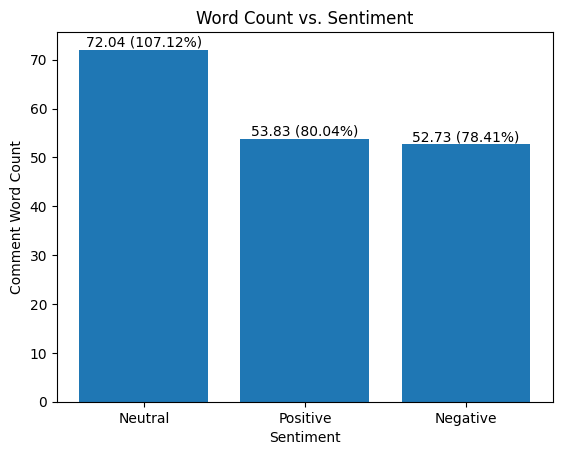

In [431]:
values = category_word_count

# calculate percentages
total = df['word_count'].sum()/len(df)
percentages = [(value / total) * 100 for value in values]

# plot the bar graph
fig, ax = plt.subplots()
ax.bar(categories, values)
ax.set_title('Word Count vs. Sentiment')
ax.set_xlabel('Sentiment')
ax.set_ylabel('Comment Word Count')

# add percentages as annotations above each bar
for i, value in enumerate(values):
    ax.annotate(f'{value} ({percentages[i]:.2f}%)', xy=(i, value), ha='center', va='bottom')

### Average Length of Negative comment under toxic, severe_toxic, obscene, threat, insult, identity_hate

In [425]:
categories=df.columns[2:8].tolist()
category_word_count= []
for i in categories:
    category_word_count.append(round(int(df.loc[df[i] == 1, ['word_count']].sum())/len(df.loc[df[i] == 1]),2))

pd.DataFrame({'categories': categories, 'word_count': category_word_count})

,categories,word_count
0,toxic,51.30
1,severe_toxic,75.63
2,obscene,49.58
3,threat,55.30
4,insult,48.29
5,identity_hate,52.05


In [427]:
#average word count for negative comment
round(int(df.loc[df['sentiment'] == 'Negative', ['word_count']].sum())/len(df.loc[df['sentiment'] == 'Negative']),2)

52.73

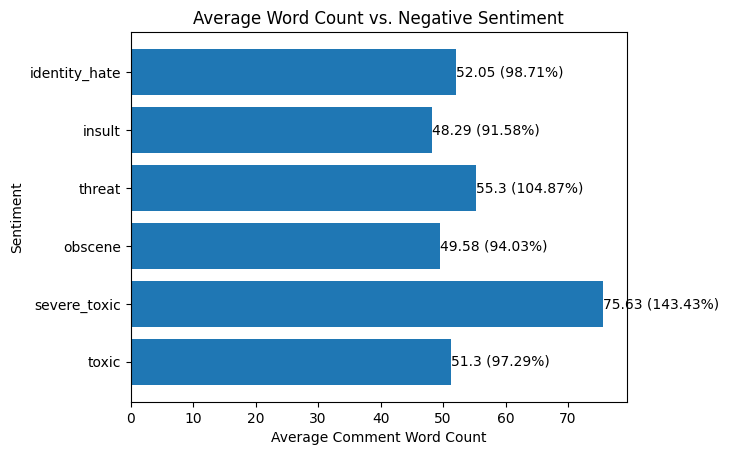

In [377]:
# sample data
values = category_word_count

# calculate percentages
total = int(df.loc[df['sentiment'] == 'Negative', ['word_count']].sum())/len(df.loc[df['sentiment'] == 'Negative'])
percentages = [(value / total) * 100 for value in values]

# plot the horizontal bar graph
fig, ax = plt.subplots()
ax.barh(categories, values)
ax.set_title('Average Word Count vs. Negative Sentiment')
ax.set_xlabel('Average Comment Word Count')
ax.set_ylabel('Sentiment')

# add percentages as annotations to the right of each bar
for i, value in enumerate(values):
    ax.annotate(f'{value} ({percentages[i]:.2f}%)', xy=(value, i), ha='left', va='center')

plt.show()

### Creating WordCloud<br>
show frequently used words in each category

Split dataset into 6 categories: toxic, severe_toxic, obscene, threat, insult, and identity_hate. df_category stucture = {id,comment,categotry}

In [378]:
df_toxic = df.loc[:,['id','comment_text','toxic']]
df_severe = df.loc[:,['id','comment_text','severe_toxic']]
df_obscene = df.loc[:,['id','comment_text','obscene']]
df_threat = df.loc[:,['id','comment_text','threat']]
df_insult = df.loc[:,['id','comment_text','insult']]
df_hate = df.loc[:,['id','comment_text','identity_hate']]

In [379]:
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from nltk.corpus import stopwords

In [380]:
def wordcloud(df, label):
    
    # Print only rows where the toxic category label value is 1 (ie. the comment is toxic)
    subset=df[df[label]==1]
    text=subset.comment_text.values
    wc= WordCloud(background_color="black",max_words=4000)

    wc.generate(" ".join(text))

    plt.figure(figsize=(20,20))
    plt.subplot(221)
    plt.axis("off")
    plt.title("Words frequented in {}".format(label), fontsize=20)
    plt.imshow(wc.recolor(colormap= 'gist_earth' , random_state=244), alpha=0.98)

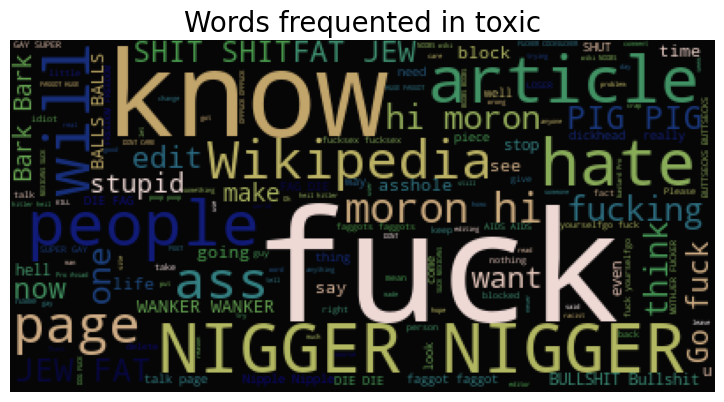

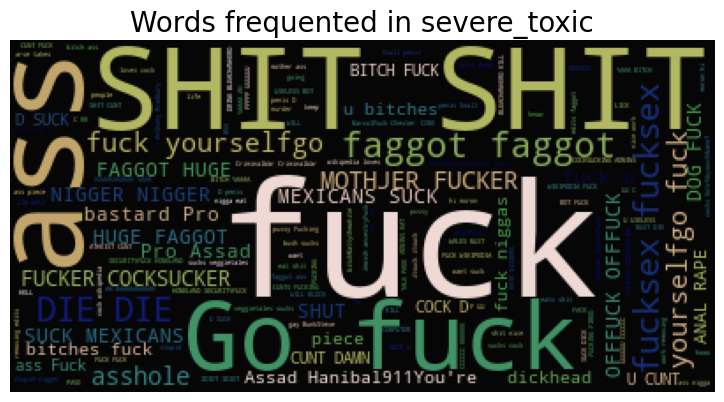

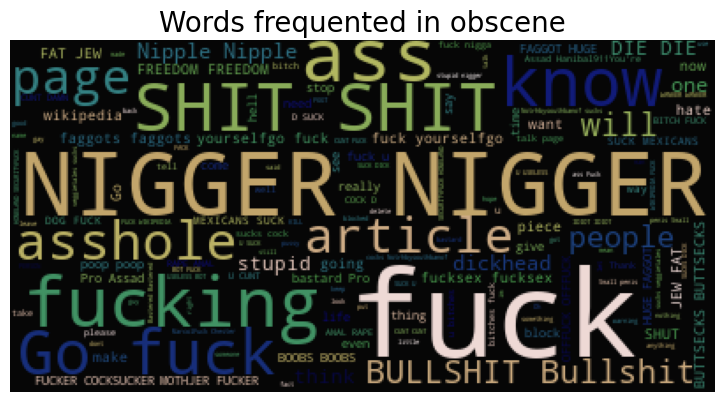

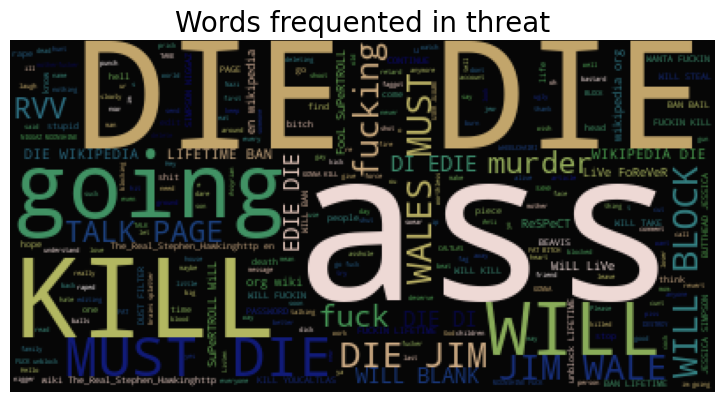

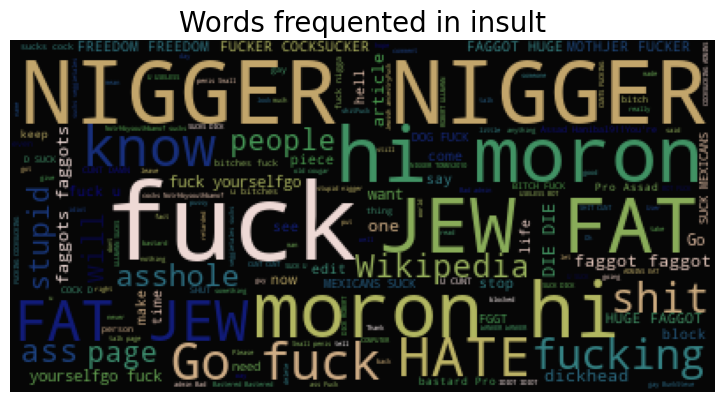

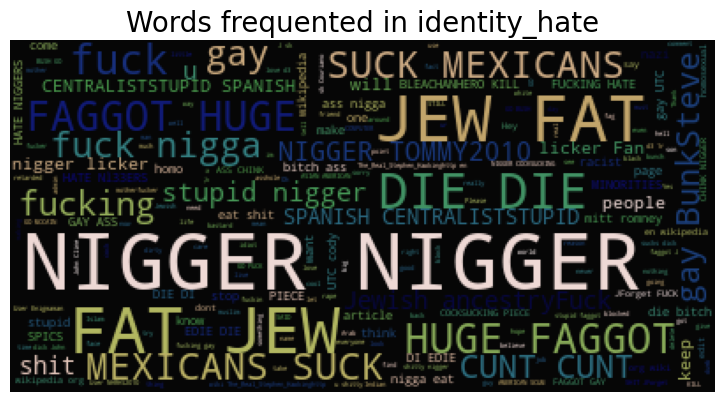

In [381]:
category_df=[df_toxic,df_severe,df_obscene,df_threat,df_insult,df_hate]

for i in range(len(category_df)):
    wordcloud(category_df[i],category_df[i].columns[2])

Creating Network graph
show frequently used words in all categories

In [7]:
import networkx as nx
from collections import Counter


In [8]:
# # Filter data to only include comments labeled as all categories
all_categories_data = df[(df['toxic'] == 1) &
                         (df['severe_toxic'] == 1) &
                         (df['obscene'] == 1) &
                         (df['threat'] == 1) &
                         (df['insult'] == 1) &
                         (df['identity_hate'] == 1)]


In [13]:
import nltk


# Load the stop words for English
stop_words = nltk.corpus.stopwords.words('english')

# Add stop words to the existing exclude_words list
exclude_words =  stop_words

# Remove duplicates from the list
exclude_words = list(set(exclude_words))


In [14]:
# Concatenate all comments into a single string
all_comments = ' '.join(all_categories_data['comment_text'])

# Split the string into individual words, excluding words in the exclusion list
words = [word for word in all_comments.split() if word.lower()
         not in exclude_words]

# Calculate the frequency of each word
word_freq = Counter(words)


In [15]:

# Get the top 50 most common words
top_words = [word[0] for word in word_freq.most_common(50)]

# Create a dictionary to store co-occurrence counts
co_occur_dict = {}

# Loop through each comment in the data
for comment in all_categories_data['comment_text']:
    # Split the comment into individual words
    comment_words = comment.split()
    # Loop through each pair of words in the comment
    for i in range(len(comment_words)):
        for j in range(i+1, len(comment_words)):
            # Check if both words are in the top 50 most common words
            if comment_words[i] in top_words and comment_words[j] in top_words:
                # Increment the co-occurrence count for the pair of words
                pair = tuple(sorted([comment_words[i], comment_words[j]]))
                if pair in co_occur_dict:
                    co_occur_dict[pair] += 1
                else:
                    co_occur_dict[pair] = 1


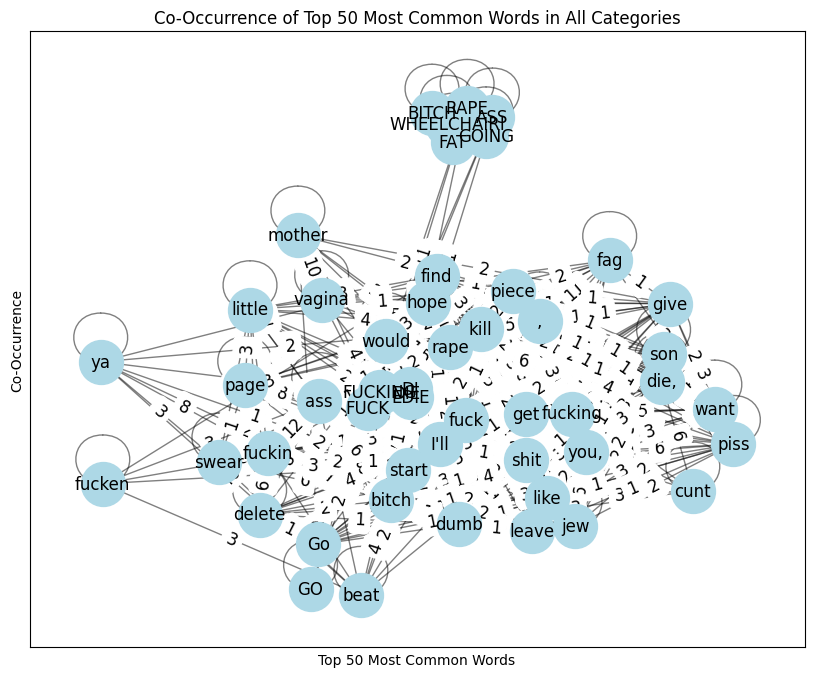

In [16]:
# Create an empty graph
G = nx.Graph()

# Add nodes
for word in top_words:
    G.add_node(word)

# Add edges
for pair, weight in co_occur_dict.items():
    node1, node2 = pair
    G.add_edge(node1, node2, weight=weight)

# Set the positions of the nodes using the spring layout algorithm
pos = nx.spring_layout(G, k=2, iterations=50)

fig, ax = plt.subplots(figsize=(10, 8))

nx.draw_networkx_nodes(G, pos, node_size=1000, node_color='lightblue', ax=ax)
nx.draw_networkx_edges(G, pos, width=1, alpha=0.5, ax=ax)
nx.draw_networkx_labels(G, pos, font_size=12, font_family='sans-serif', ax=ax)

edge_labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(
    G, pos, edge_labels=edge_labels, font_size=12, ax=ax)

ax.set_xlabel('Top 50 Most Common Words')
ax.set_ylabel('Co-Occurrence')
ax.set_title('Co-Occurrence of Top 50 Most Common Words in All Categories')

plt.show()


Showing words that uniquely exist in the category alone

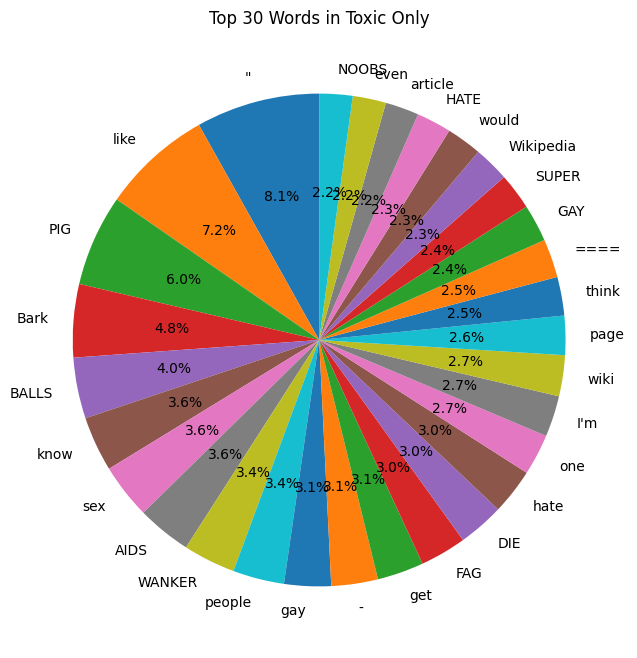

In [18]:
#common words that uniquely exist in toxic only
data_toxic = df[(df['toxic'] == 1) &
                (df['severe_toxic'] == 0) &
                (df['obscene'] == 0) &
                (df['threat'] == 0) &
                (df['insult'] == 0) &
                (df['identity_hate'] == 0)]


# Concatenate all comments into a single string
all_comments = ' '.join(data_toxic['comment_text'])


# Split the string into individual words, excluding words in the exclusion list
words = [word for word in all_comments.split() if word.lower()
         not in exclude_words]

# Count the frequency of each word in the list
word_counts = Counter(words)


# Get the top 30 words and their frequencies
top_words = word_counts.most_common(30)
labels = [word for word, count in top_words]
counts = [count for word, count in top_words]

# Create a pie chart
fig, ax = plt.subplots(figsize=(8, 8))
ax.pie(counts, labels=labels, autopct='%1.1f%%', startangle=90)

# Add a title
ax.set_title("Top 30 Words in Toxic Only")

# Show the chart
plt.show()


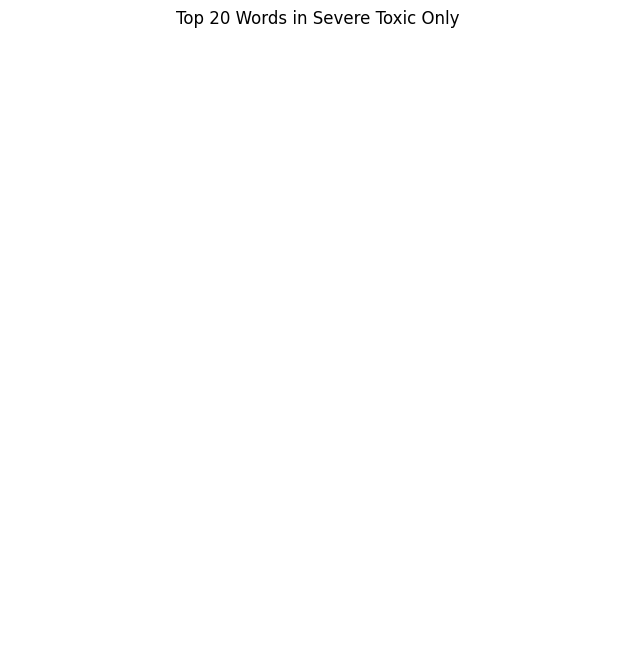

In [19]:
#common words that uniquely exist in severe toxic only
data_severe_toxic = df[(df['toxic'] == 0) &
                       (df['severe_toxic'] == 1) &
                       (df['obscene'] == 0) &
                       (df['threat'] == 0) &
                       (df['insult'] == 0) &
                       (df['identity_hate'] == 0)]


# Concatenate all comments into a single string
all_comments = ' '.join(data_severe_toxic['comment_text'])


# Split the string into individual words, excluding words in the exclusion list
words = [word for word in all_comments.split() if word.lower()
         not in exclude_words]


# Count the frequency of each word in the list
word_counts = Counter(words)


# Get the top 20 words and their frequencies
top_words = word_counts.most_common(20)
labels = [word for word, count in top_words]
counts = [count for word, count in top_words]

# Create a pie chart
fig, ax = plt.subplots(figsize=(8, 8))
ax.pie(counts, labels=labels, autopct='%1.1f%%', startangle=90)

# Add a title
ax.set_title("Top 20 Words in Severe Toxic Only")

# Show the chart
plt.show()


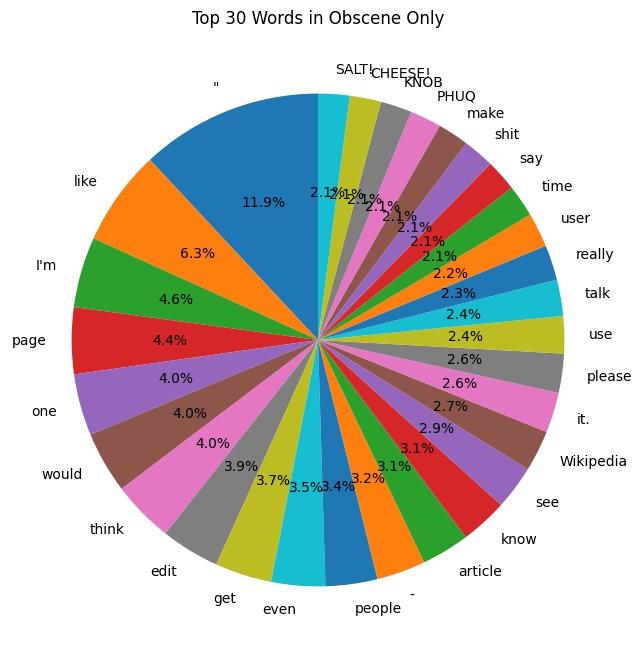

In [21]:
# Common obscene words that dont fall under other category
data_obscene = df[(df['toxic'] == 0) &
                  (df['severe_toxic'] == 0) &
                  (df['obscene'] == 1) &
                  (df['threat'] == 0) &
                  (df['insult'] == 0) &
                  (df['identity_hate'] == 0)]


# Concatenate all comments into a single string
all_comments = ' '.join(data_obscene['comment_text'])


# Split the string into individual words, excluding words in the exclusion list
words = [word for word in all_comments.split() if word.lower()
         not in exclude_words]


# Count the frequency of each word in the list
word_counts = Counter(words)


# Get the top 30 words and their frequencies
top_words = word_counts.most_common(30)
labels = [word for word, count in top_words]
counts = [count for word, count in top_words]

# Create a pie chart
fig, ax = plt.subplots(figsize=(8, 8))
ax.pie(counts, labels=labels, autopct='%1.1f%%', startangle=90)

# Add a title
ax.set_title("Top 30 Words in Obscene Only")

# Show the chart
plt.show()


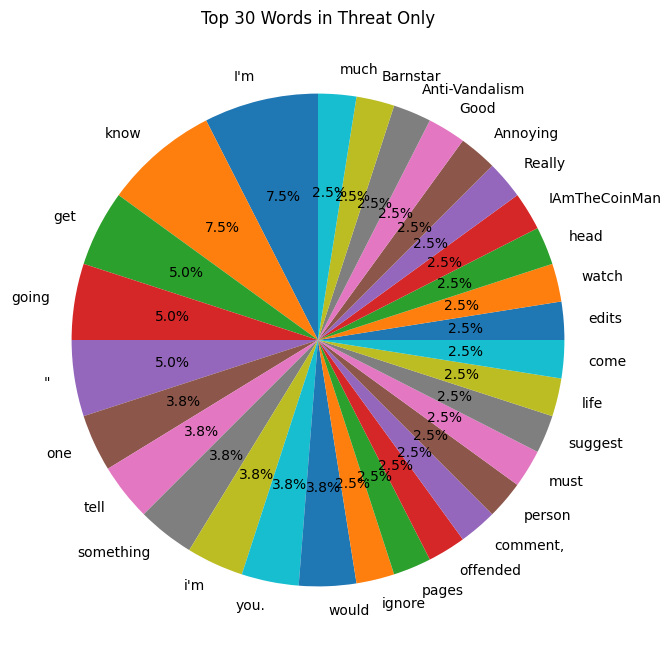

In [22]:
# Filter data to only include comments labeled in threat only 
data_threat = df[(df['toxic'] == 0) &
                 (df['severe_toxic'] == 0) &
                 (df['obscene'] == 0) &
                 (df['threat'] == 1) &
                 (df['insult'] == 0) &
                 (df['identity_hate'] == 0)]


# Concatenate all comments into a single string
all_comments = ' '.join(data_threat['comment_text'])


# Split the string into individual words, excluding words in the exclusion list
words = [word for word in all_comments.split() if word.lower()
         not in exclude_words]


# Count the frequency of each word in the list
word_counts = Counter(words)


# Get the top 30 words and their frequencies
top_words = word_counts.most_common(30)
labels = [word for word, count in top_words]
counts = [count for word, count in top_words]

# Create a pie chart
fig, ax = plt.subplots(figsize=(8, 8))
ax.pie(counts, labels=labels, autopct='%1.1f%%', startangle=90)

# Add a title
ax.set_title("Top 30 Words in Threat Only")

# Show the chart
plt.show()


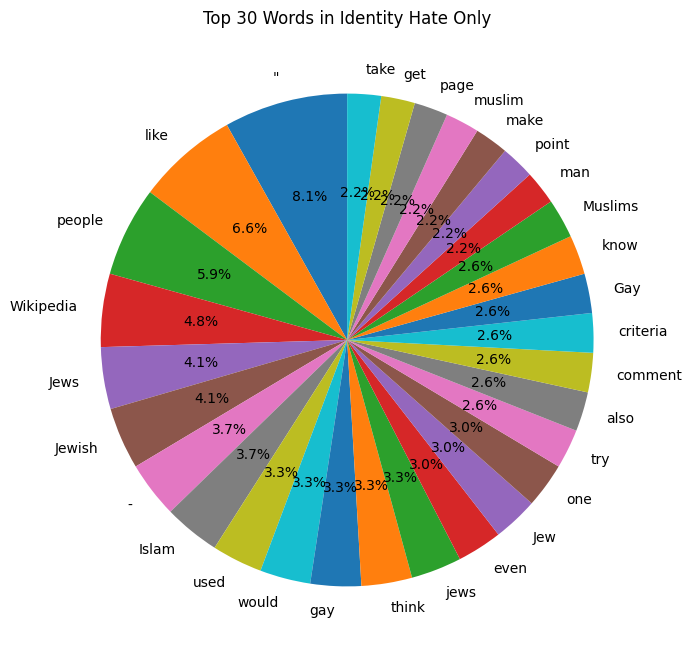

In [25]:
# Filter data to only include comments labeled in identity only
data_identity_hate = df[(df['toxic'] == 0) &
                        (df['severe_toxic'] == 0) &
                        (df['obscene'] == 0) &
                        (df['threat'] == 0) &
                        (df['insult'] == 0) &
                        (df['identity_hate'] == 1)]


# Concatenate all comments into a single string
all_comments = ' '.join(data_identity_hate['comment_text'])


# Split the string into individual words, excluding words in the exclusion list
words = [word for word in all_comments.split() if word.lower()
         not in exclude_words]


# Count the frequency of each word in the list
word_counts = Counter(words)


# Get the top 30 words and their frequencies
top_words = word_counts.most_common(30)
labels = [word for word, count in top_words]
counts = [count for word, count in top_words]

# Create a pie chart
fig, ax = plt.subplots(figsize=(8, 8))
ax.pie(counts, labels=labels, autopct='%1.1f%%', startangle=90)

# Add a title
ax.set_title("Top 30 Words in Identity Hate Only")

# Show the chart
plt.show()


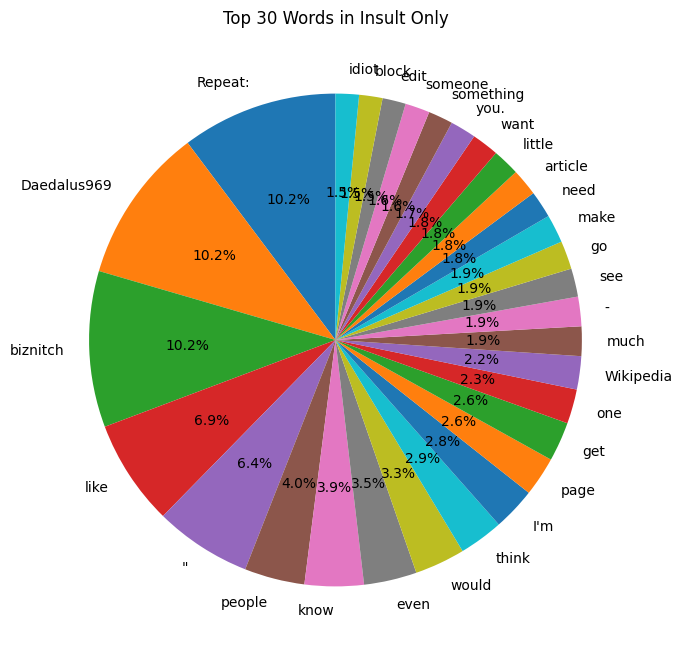

In [26]:
# Filter data to only include comments labeled in insult only
data_insult = df[(df['toxic'] == 0) &
                 (df['severe_toxic'] == 0) &
                 (df['obscene'] == 0) &
                 (df['threat'] == 0) &
                 (df['insult'] == 1) &
                 (df['identity_hate'] == 0)]


# Concatenate all comments into a single string
all_comments = ' '.join(data_insult['comment_text'])


# Split the string into individual words, excluding words in the exclusion list
words = [word for word in all_comments.split() if word.lower()
         not in exclude_words]


# Count the frequency of each word in the list
word_counts = Counter(words)


# Get the top 30 words and their frequencies
top_words = word_counts.most_common(30)
labels = [word for word, count in top_words]
counts = [count for word, count in top_words]

# Create a pie chart
fig, ax = plt.subplots(figsize=(8, 8))
ax.pie(counts, labels=labels, autopct='%1.1f%%', startangle=90)

# Add a title
ax.set_title("Top 30 Words in Insult Only")

# Show the chart
plt.show()


### create ML pipeline

In [382]:
from tensorflow.keras.layers import TextVectorization

In [383]:
X = df['comment_text']
y = df[df.columns[2:8]].values

In [384]:
MAX_FEATURES = 200000 # number of words in the vocab

In [385]:
vectorizer = TextVectorization(max_tokens=MAX_FEATURES,
                               output_sequence_length=1800,
                               output_mode='int')

In [386]:
vectorizer.adapt(X.values)

In [387]:
vectorized_text = vectorizer(X.values)

In [388]:
#MCSHBAP - map, chache, shuffle, batch, prefetch  from_tensor_slices, list_file
dataset = tf.data.Dataset.from_tensor_slices((vectorized_text, y))
dataset = dataset.cache()
dataset = dataset.shuffle(160000)
dataset = dataset.batch(16)
dataset = dataset.prefetch(8) # helps bottlenecks

In [389]:
train = dataset.take(int(len(dataset)*.7))
val = dataset.skip(int(len(dataset)*.7)).take(int(len(dataset)*.2))
test = dataset.skip(int(len(dataset)*.9)).take(int(len(dataset)*.1))

### Create Sequential Model

In [390]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Bidirectional, Dense, Embedding

In [391]:
model = Sequential()
# Create the embedding layer 
model.add(Embedding(MAX_FEATURES+1, 32))
# Bidirectional LSTM Layer
model.add(Bidirectional(LSTM(32, activation='tanh')))
# Feature extractor Fully connected layers
model.add(Dense(128, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
# Final layer 
model.add(Dense(6, activation='sigmoid'))

In [392]:
model.compile(loss='BinaryCrossentropy', optimizer='Adam')

In [393]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 32)          6400032   
                                                                 
 bidirectional_1 (Bidirectio  (None, 64)               16640     
 nal)                                                            
                                                                 
 dense_4 (Dense)             (None, 128)               8320      
                                                                 
 dense_5 (Dense)             (None, 256)               33024     
                                                                 
 dense_6 (Dense)             (None, 128)               32896     
                                                                 
 dense_7 (Dense)             (None, 6)                 774       
                                                      

Train Model

In [396]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [400]:
history = model.fit(train, epochs=3, validation_data=val)

Epoch 1/3
6981/6981 [==============================] - 2121s 304ms/step - loss: 0.0452 - accuracy: 0.9862 - val_loss: 0.0416 - val_accuracy: 0.9941
Epoch 2/3
6981/6981 [==============================] - 2128s 305ms/step - loss: 0.0394 - accuracy: 0.9878 - val_loss: 0.0352 - val_accuracy: 0.9916
Epoch 3/3
6981/6981 [==============================] - 6410s 918ms/step - loss: 0.0355 - accuracy: 0.9900 - val_loss: 0.0335 - val_accuracy: 0.9939


<Figure size 800x500 with 0 Axes>

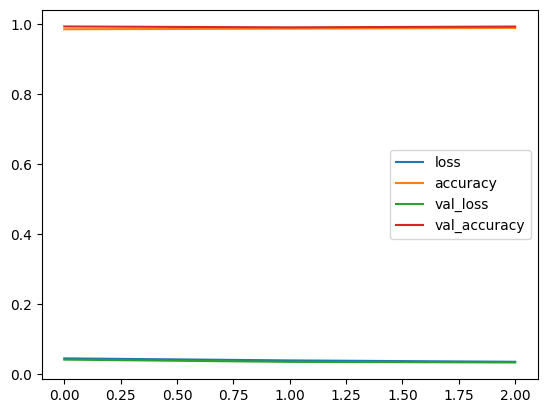

In [401]:
plt.figure(figsize=(8,5))
pd.DataFrame(history.history).plot()
plt.show()

## Make Predictions

In [402]:
input_text = vectorizer('You freaking suck! I am going to hit you.')

In [ ]:
res = model.predict(np.expand_dims(input_text,0))

1/1 [==============================] - 0s 396ms/step


In [ ]:
df.columns[2:]

Index(['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate',
       'sentiment'],
      dtype='object')

In [ ]:
(res > 0.5).astype(int)

array([[1, 1, 0, 1, 0, 1]])

In [ ]:
batch_X, batch_y = test.as_numpy_iterator().next()

In [ ]:
(model.predict(batch_X) > 0.5).astype(int)

1/1 [==============================] - 0s 50ms/step


array([[1, 0, 0, 0, 0, 1],
       [1, 1, 0, 0, 0, 1],
       [1, 1, 1, 1, 0, 1],
       [1, 1, 0, 0, 0, 1],
       [1, 1, 0, 1, 0, 1],
       [1, 1, 0, 0, 1, 1],
       [1, 1, 0, 0, 1, 1],
       [1, 1, 1, 0, 0, 1],
       [1, 1, 0, 0, 0, 1],
       [1, 1, 0, 1, 0, 1],
       [1, 1, 0, 0, 0, 1],
       [1, 1, 0, 1, 0, 1],
       [1, 1, 0, 0, 0, 1],
       [1, 1, 0, 0, 0, 1],
       [1, 1, 0, 0, 0, 1],
       [1, 1, 0, 0, 0, 1]])

In [ ]:
res.shape

(1, 6)

## Evaluate Model

In [ ]:
from tensorflow.keras.metrics import Precision, Recall, CategoricalAccuracy

In [ ]:
pre = Precision()
re = Recall()
acc = CategoricalAccuracy()

In [ ]:
for batch in test.as_numpy_iterator(): 
    # Unpack the batch 
    X_true, y_true = batch
    # Make a prediction 
    yhat = model.predict(X_true)
    
    # Flatten the predictions
    y_true = y_true.flatten()
    yhat = yhat.flatten()
    
    pre.update_state(y_true, yhat)
    re.update_state(y_true, yhat)
    acc.update_state(y_true, yhat)

1/1 [==============================] - 0s 49ms/step


In [ ]:
print(f'Precision: {pre.result().numpy()}, Recall:{re.result().numpy()}, Accuracy:{acc.result().numpy()}')

Precision: 0.03246362879872322, Recall:0.6048910021781921, Accuracy:0.0


In [ ]:
%pip install gradio jinja2

Note: you may need to restart the kernel to use updated packages.


In [ ]:
import gradio as gr

/Users/xueer/miniforge3/envs/NTU-Python/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
#model.save('toxicity.h5')

In [ ]:
model = tf.keras.models.load_model('toxicity.h5')

In [ ]:
def score_comment(comment):
    vectorized_comment = vectorizer([comment])
    results = model.predict(vectorized_comment)
    
    text = ''
    for idx, col in enumerate(df.columns[2:]):
        text += '{}: {}\n'.format(col, results[0][idx]>0.5)
    
    return text

In [ ]:
interface = gr.Interface(fn=score_comment, 
                         inputs=gr.inputs.Textbox(lines=2, placeholder='Comment to score'),
                        outputs='text')

/Users/xueer/miniforge3/envs/NTU-Python/lib/python3.10/site-packages/gradio/inputs.py:27: UserWarning: Usage of gradio.inputs is deprecated, and will not be supported in the future, please import your component from gradio.components
  warnings.warn(
/Users/xueer/miniforge3/envs/NTU-Python/lib/python3.10/site-packages/gradio/deprecation.py:40: UserWarning: `optional` parameter is deprecated, and it has no effect
  warnings.warn(value)
/Users/xueer/miniforge3/envs/NTU-Python/lib/python3.10/site-packages/gradio/deprecation.py:40: UserWarning: `numeric` parameter is deprecated, and it has no effect
  warnings.warn(value)


In [ ]:
interface.launch(share=True)

Running on local URL:  http://127.0.0.1:7861
Running on public URL: https://23892eff18f6c453a8.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades (NEW!), check out Spaces: https://huggingface.co/spaces
